In [3]:
#This script analyzes the temperature variance across rooms from our first testbed. 
#It defined the comfortable operation index and computes it. 
#Based on measurements from a vent, it computes the times where hvac was on or off. 
import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib import dates
import math
import numpy as np

                     Date    hvacOn   ex1  bed2  bed3  bed1  bed4  lRoom  \
0     2023-04-06 22:50:00  43.89762  21.5  22.4  21.1  21.4  22.2   21.4   
1     2023-04-06 22:52:00  37.81175  21.7  22.6  21.2  21.6  22.4   21.9   
2     2023-04-06 22:53:00  33.59842  21.8  22.7  21.3  21.7  22.6   22.1   
3     2023-04-06 22:54:00  31.72584  21.8  22.8  21.4  21.8  22.6   22.2   
4     2023-04-06 22:55:00  29.85327  21.8  22.7  21.3  21.7  22.5   22.1   
...                   ...       ...   ...   ...   ...   ...   ...    ...   
19116 2023-04-23 17:08:00  27.51254  22.2  21.5  19.6  21.4  21.8   21.7   
19117 2023-04-23 17:09:00  27.04440  22.1  21.4  19.6  21.4  21.7   21.6   
19118 2023-04-23 17:10:00  27.04440  22.1  21.3  19.7  21.3  21.6   21.5   
19119 2023-04-23 17:11:00       NaN   NaN   NaN  19.6  21.3  21.6    NaN   
19120                 NaT       NaN   NaN   NaN   NaN   NaN   NaN    NaN   

       outside  
0         24.8  
1         18.6  
2         14.4  
3         13.1  
4 

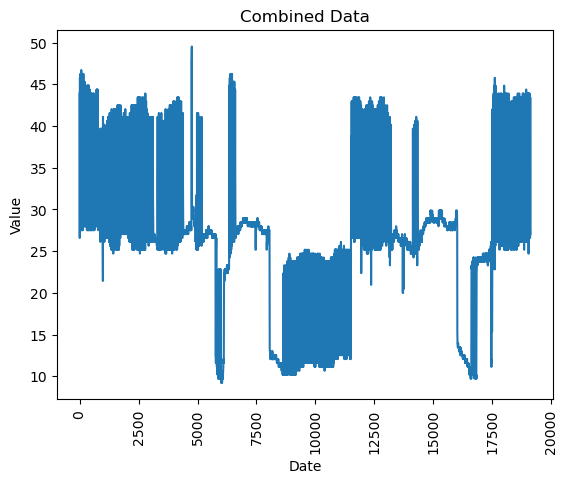

<Axes: xlabel='Date'>

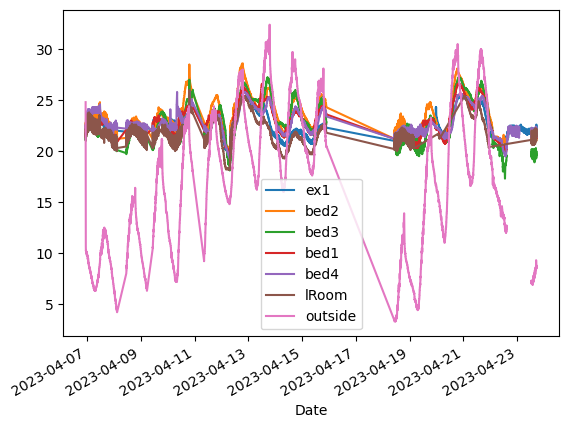

In [4]:
# set the directory path
dir_path = 'Data(4-18)'
#dir_path = 'test_data_2'
# get a list of all files in the directory
file_names = os.listdir(dir_path)

# filter the list to include only csv files
file_names = [f for f in file_names if f.endswith('.csv')]

# read the first file to create the initial dataframe
first_file_path = os.path.join(dir_path, file_names[0])
initial_df = pd.read_csv(first_file_path, header=None, names=['Date', f'{os.path.splitext(file_names[0])[0]}'])

# convert the Date column to a datetime object
initial_df['Date'] = pd.to_datetime(initial_df['Date'], format='%Y-%m-%d %H:%M:%S')

# iterate over the remaining files and merge their data with the combined dataframe
for file_name in file_names[1:]:
    # read the csv file into a pandas DataFrame
    file_path = os.path.join(dir_path, file_name)
    df = pd.read_csv(file_path, header=None, names=['Date', f'{os.path.splitext(file_name)[0]}'])

    # convert the Date column to a datetime object
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d %H:%M:%S')

    # merge the current dataframe with the combined dataframe based on the Date column
    initial_df = pd.merge(initial_df, df, on='Date')

# set the Date column as the index
#combined_df.set_index('Date', inplace=True)

# set the directory path
dir_path = 'Data(4-23)'
#dir_path = 'test_data_2'
# get a list of all files in the directory
file_names = os.listdir(dir_path)

# filter the list to include only csv files
file_names = [f for f in file_names if f.endswith('.csv')]

# read the first file to create the initial dataframe
first_file_path = os.path.join(dir_path, file_names[0])
additional_df = pd.read_csv(first_file_path, header=None, names=['Date', f'{os.path.splitext(file_names[0])[0]}'])

# convert the Date column to a datetime object
additional_df['Date'] = pd.to_datetime(additional_df['Date'], format='%Y-%m-%d %H:%M:%S')

# iterate over the remaining files and merge their data with the combined dataframe
for file_name in file_names[1:]:
    # read the csv file into a pandas DataFrame
    file_path = os.path.join(dir_path, file_name)
    df = pd.read_csv(file_path, header=None, names=['Date', f'{os.path.splitext(file_name)[0]}'])

    # convert the Date column to a datetime object
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d %H:%M:%S')

    # merge the current dataframe with the combined dataframe based on the Date column
    additional_df = pd.merge(additional_df, df, on='Date',how='outer')


combined_df = pd.concat([initial_df, additional_df], ignore_index=True)
    

print(combined_df)


# replace values above the threshold with NaN
combined_df.loc[combined_df['lRoom'] > 60, 'lRoom'] = np.nan

# interpolate the NaN values
combined_df['lRoom'] = combined_df['lRoom'].interpolate()

plt.plot(combined_df.index, combined_df['hvacOn'])
plt.xlabel('Date')
#plt.gca().xaxis.set_major_formatter(dates.DateFormatter('%m/%d/%y %H:%M:%S'))
plt.ylabel('Value')
plt.title('Combined Data')
plt.xticks(rotation=90)
plt.show()

# plot the data
combined_df.plot(x='Date', y=['ex1','bed2','bed3','bed1','bed4','lRoom','outside'])


In [5]:
#converting hvacOn to Binary heating 
# when heating =1, otherwise=0

from sklearn.preprocessing import MinMaxScaler

def peak_finder(array):
    pits=[]
    for i in range(len(array)-2):
        if array[i]>=array[i-1] and array[i]>=array[i+1] and array[i]>35:
            
            pits.append(i)
    return pits
    
    
combined_df['heating'] = 0

# Find peaks in hvacOn column with a value greater than threshold
#peaks, properties = find_peaks(combined_df['hvacOn'], height=threshold)
peaks=peak_finder(combined_df['hvacOn'].values)


vals=combined_df['hvacOn'].values
print(vals[638:650])

for peak in peaks:  
    
    if peak==0:
        continue
        
    current_date = peak
    current_value=combined_df.at[current_date, 'hvacOn']
    previous_date=peak-1

    previous_value = combined_df.at[previous_date, 'hvacOn']

    #print(combined_df.at[current_date, 'hvacOn'],previous_value)
    # Keep assigning 1's until the difference becomes 0
    while (current_value > previous_value):
        combined_df.at[current_date, 'heating'] = 1
 
        #update current and previous step by one step
    
        current_date = current_date-1
        current_value=combined_df.at[current_date, 'hvacOn']
        previous_date=previous_date-1
 
        previous_value = combined_df.at[previous_date, 'hvacOn']
    
        if current_date < combined_df.index[0]: # if we reach the beginning of the DataFrame
            break
            
     

# create a scaler object
scaler = MinMaxScaler()

# fit the scaler to the hvacOn column
scaler.fit(combined_df[['hvacOn']])
       

[31.72584 30.32144 29.85327 28.91698 28.44887 28.44887 28.44887 27.98069
 27.98069 32.19402 37.81175 40.15244]


/Users/ozanbaris/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/ozanbaris/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/ozanbaris/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


MinMaxScaler()

In [6]:
#converting hvacOn to Binary cooling
# when cooling=-1, otherwise=0


from scipy.signal import find_peaks
import numpy as np


def find_pits(array):
    pits=[]
    print(array)
    for i in range(len(array)-2):
        if array[i]<=array[i-1] and array[i]<=array[i+1] and array[i]<20:
            
            pits.append(i)
    return pits


combined_df['cooling'] = 0    
    
#Apply the convolution to the column
kernel = np.array([0.33, 0.33, 0.33])
combined_df['hvacOn_convolved'] = np.convolve(combined_df['hvacOn'] , kernel, mode='same')

#find pits
neg_peaks= find_pits(combined_df['hvacOn_convolved'].values)


for neg_peak in neg_peaks:  
    
    if neg_peak==0:
        continue
    current_date = neg_peak
    current_value=combined_df.at[current_date, 'hvacOn_convolved']
    previous_date=neg_peak-1
    previous_value = combined_df.at[previous_date, 'hvacOn_convolved']

    #print(combined_df.at[current_date, 'hvacOn'],previous_value)
    # Keep assigning 1's until the difference becomes 0
    while (current_value < previous_value or (current_value-0.5 < previous_value and current_value<20)):
        combined_df.at[current_date, 'cooling'] = -1
 
        #update current and previous step by one step
    
        current_date = current_date-1
        current_value=combined_df.at[current_date, 'hvacOn_convolved']
        previous_date=previous_date-1
        previous_value = combined_df.at[previous_date, 'hvacOn_convolved']
    
        if current_date < combined_df.index[0]: # if we reach the beginning of the DataFrame
            break
            

#print([val for val in combined_df["heating"].values])            
# import MinMaxScaler from scikit-learn
from sklearn.preprocessing import MinMaxScaler

# create a scaler object
scaler = MinMaxScaler()

# fit the scaler to the hvacOn column
scaler.fit(combined_df[['hvacOn_convolved']])


[26.9640921 38.0515707 34.0348833 ...        nan        nan        nan]


/Users/ozanbaris/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/ozanbaris/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/ozanbaris/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


MinMaxScaler()

In [8]:
#removing the hvacOn and hvacOn_convolved data

new_df = combined_df.iloc[:, [0,2,7, 5,3,4,6,9,10,8]]
print(new_df)


                     Date   ex1  lRoom  bed1  bed2  bed3  bed4  heating  \
0     2023-04-06 22:50:00  21.5   21.4  21.4  22.4  21.1  22.2        0   
1     2023-04-06 22:52:00  21.7   21.9  21.6  22.6  21.2  22.4        0   
2     2023-04-06 22:53:00  21.8   22.1  21.7  22.7  21.3  22.6        0   
3     2023-04-06 22:54:00  21.8   22.2  21.8  22.8  21.4  22.6        0   
4     2023-04-06 22:55:00  21.8   22.1  21.7  22.7  21.3  22.5        0   
...                   ...   ...    ...   ...   ...   ...   ...      ...   
19116 2023-04-23 17:08:00  22.2   21.7  21.4  21.5  19.6  21.8        0   
19117 2023-04-23 17:09:00  22.1   21.6  21.4  21.4  19.6  21.7        0   
19118 2023-04-23 17:10:00  22.1   21.5  21.3  21.3  19.7  21.6        0   
19119 2023-04-23 17:11:00   NaN   21.5  21.3   NaN  19.6  21.6        0   
19120                 NaT   NaN   21.5   NaN   NaN   NaN   NaN        0   

       cooling  outside  
0            0     24.8  
1            0     18.6  
2            0     14

In [10]:
#setpoint schedule is manually entered.
data = [['2023-04-02 14:30:00', 70, 'Heating'],
        ['2023-04-04 21:30:00', 68, 'Cooling'],
        ['2023-04-05 00:12:00', 71, 'Cooling'],
        ['2023-04-06 00:30:00', 72, 'Cooling'],
        ['2023-04-06 21:00:00', 70, 'Heating'],
        ['2023-04-07 11:30:00', 70, 'Heating'],
        ['2023-04-10 19:00:00', 80, 'Heating'],
        ['2023-04-10 19:20:00', 60, 'Heating'],
        ['2023-04-10 19:40:00', 70, 'Heating'],
        ['2023-04-11 21:52:00', 60, 'Cooling'],
        ['2023-04-11 22:12:00', 80, 'Cooling'],
        ['2023-04-11 22:32:00', 70, 'Cooling'],
        ['2023-04-12 07:30:00', 70, 'Heating'],
        ['2023-04-13 12:05:00', 70, 'Cooling'],
        ['2023-04-15 10:00:00', 71, 'Cooling'],
        ['2023-04-17 09:52:00', 69, 'Heating'],
        ['2023-04-19 22:54:00', 69, 'Testing'],
        ['2023-04-19 23:36:00', 69, 'Testing']]

df = pd.DataFrame(data, columns=['Date', 'setpoint', 'mode'])

# Convert the 'Date' column to datetime type
df['Date'] = pd.to_datetime(df['Date'])

# Create a new dataframe for one-minute intervals
set_df = pd.DataFrame(columns=['Date', 'setpoint', 'mode'])

for index, row in df.iterrows():
    # If it's the first row, add it to the new dataframe and continue
    if index == 0:
        set_df = pd.concat([set_df, pd.DataFrame([row])], ignore_index=True)
        continue
    
    # Calculate the time difference between the current row and the previous row
    time_diff = row['Date'] - df.iloc[index - 1]['Date']
    
    # If the time difference is greater than one minute, fill in the missing minutes
    if time_diff > pd.Timedelta(minutes=1):
        missing_minutes = time_diff.seconds // 60
        for i in range(1, missing_minutes + 1):
            new_time = df.iloc[index - 1]['Date'] + pd.Timedelta(minutes=i)
            new_row = pd.DataFrame([{'Date': new_time, 'setpoint': df.iloc[index - 1]['setpoint'], 'mode': df.iloc[index - 1]['mode']}])
            set_df = pd.concat([set_df, new_row], ignore_index=True)
    
    # Add the current row to the new dataframe
    set_df = pd.concat([set_df, pd.DataFrame([row])], ignore_index=True)

# Fill in any remaining missing minutes with the last setpoint and mode
last_time = set_df['Date'].max()
while last_time < pd.Timestamp.now():
    last_time += pd.Timedelta(minutes=1)
    new_row = pd.DataFrame([{'Date': last_time, 'setpoint': set_df.iloc[-1]['setpoint'], 'mode': set_df.iloc[-1]['mode']}])
    set_df = pd.concat([set_df, new_row], ignore_index=True)

# Convert setpoint from Fahrenheit to Celsius
set_df['setpoint'] = (set_df['setpoint'] - 32) * 5 / 9

# Convert setpoint column to numeric data type
set_df['setpoint'] = pd.to_numeric(set_df['setpoint'], errors='coerce')

# Ensure the 'Date' column is still in datetime format if it was affected
set_df['Date'] = pd.to_datetime(set_df['Date'])

print(set_df)

/var/folders/q5/xbcszlgx0s78ry5h1wzcd5qc0000gn/T/ipykernel_13799/115905041.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  set_df = pd.concat([set_df, pd.DataFrame([row])], ignore_index=True)


                      Date   setpoint     mode
0      2023-04-02 14:30:00  21.111111  Heating
1      2023-04-02 14:31:00  21.111111  Heating
2      2023-04-02 14:32:00  21.111111  Heating
3      2023-04-02 14:33:00  21.111111  Heating
4      2023-04-02 14:34:00  21.111111  Heating
...                    ...        ...      ...
491411 2024-03-20 20:24:00  20.555556  Testing
491412 2024-03-20 20:25:00  20.555556  Testing
491413 2024-03-20 20:26:00  20.555556  Testing
491414 2024-03-20 20:27:00  20.555556  Testing
491415 2024-03-20 20:28:00  20.555556  Testing

[491416 rows x 3 columns]


In [11]:
df['setpoint'].isnull().values.any()


False

In [12]:

# Merge new_df and set_df on the Date column
merged_df = pd.merge(new_df, set_df, on='Date', how='left')

# Calculate the difference between setpoint and temperature measurement for each room
merged_df['ex1_diff'] = merged_df['setpoint'] - merged_df['ex1']
merged_df['lRoom_diff'] = merged_df['setpoint'] - merged_df['lRoom']
merged_df['bed1_diff'] = merged_df['setpoint'] - merged_df['bed1']
merged_df['bed2_diff'] = merged_df['setpoint'] - merged_df['bed2']
merged_df['bed3_diff'] = merged_df['setpoint'] - merged_df['bed3']
merged_df['bed4_diff'] = merged_df['setpoint'] - merged_df['bed4']

# # Drop unnecessary columns
# merged_df_drop = merged_df.drop(['setpoint', 'mode'], axis=1)
# merged_df_drop
merged_df

,Date,ex1,lRoom,bed1,bed2,bed3,bed4,heating,cooling,outside,setpoint,mode,ex1_diff,lRoom_diff,bed1_diff,bed2_diff,bed3_diff,bed4_diff
0,2023-04-06 22:50:00,21.5,21.4,21.4,22.4,21.1,22.2,0,0,24.8,21.111111,Heating,-0.388889,-0.288889,-0.288889,-1.288889,0.011111,-1.088889
1,2023-04-06 22:52:00,21.7,21.9,21.6,22.6,21.2,22.4,0,0,18.6,21.111111,Heating,-0.588889,-0.788889,-0.488889,-1.488889,-0.088889,-1.288889
2,2023-04-06 22:53:00,21.8,22.1,21.7,22.7,21.3,22.6,0,0,14.4,21.111111,Heating,-0.688889,-0.988889,-0.588889,-1.588889,-0.188889,-1.488889
3,2023-04-06 22:54:00,21.8,22.2,21.8,22.8,21.4,22.6,0,0,13.1,21.111111,Heating,-0.688889,-1.088889,-0.688889,-1.688889,-0.288889,-1.488889
4,2023-04-06 22:55:00,21.8,22.1,21.7,22.7,21.3,22.5,0,0,12.2,21.111111,Heating,-0.688889,-0.988889,-0.588889,-1.588889,-0.188889,-1.388889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19123,2023-04-23 17:08:00,22.2,21.7,21.4,21.5,19.6,21.8,0,0,8.5,20.555556,Testing,-1.644444,-1.144444,-0.844444,-0.944444,0.955556,-1.244444
19124,2023-04-23 17:09:00,22.1,21.6,21.4,21.4,19.6,21.7,0,0,8.6,20.555556,Testing,-1.544444,-1.044444,-0.844444,-0.844444,0.955556,-1.144444
19125,2023-04-23 17:10:00,22.1,21.5,21.3,21.3,19.7,21.6,0,0,8.6,20.555556,Testing,-1.544444,-0.944444,-0.744444,-0.744444,0.855556,-1.044444
19126,2023-04-23 17:11:00,NaN,21.5,21.3,NaN,19.6,21.6,0,0,8.6,20.555556,Testing,NaN,-0.944444,-0.744444,NaN,0.955556,-1.044444


## calculate the percentage of time 
each room maintains a temperature within ±0.5°C of the scheduled temperature

### method 1

In [13]:
merged_df.dropna(subset=['setpoint'], inplace=True)

rooms = ['ex1', 'lRoom', 'bed1', 'bed2', 'bed3', 'bed4']

# Calculate the percentage of time each room maintains the desired temperature range
for room in rooms:
    valid_data = merged_df[~merged_df[f'{room}'].isna()]  # Filter out rows with NaN values in the room column
    within_range = np.abs(valid_data[f'{room}_diff']) <= 0.5
    percentage = (within_range.sum() / len(valid_data)) * 100
    print(f"{room}: {percentage:.2f}%")


ex1: 12.40%
lRoom: 32.80%
bed1: 12.63%
bed2: 7.77%
bed3: 13.19%
bed4: 6.11%


### method 2 to check

In [14]:
def within_range_percentage(room_temp, lower_bound, upper_bound):
    within_range = (room_temp >= lower_bound) & (room_temp <= upper_bound)
    percentage = within_range.mean() * 100
    return percentage

upper_bound = merged_df['setpoint'] + 0.5
lower_bound = merged_df['setpoint'] - 0.5
for room in rooms:
    percentage = within_range_percentage(merged_df[room], lower_bound, upper_bound)
    print(f"{room}: {percentage:.2f}% of the time within ±0.5°C of the scheduled temperature")


ex1: 12.40% of the time within ±0.5°C of the scheduled temperature
lRoom: 32.80% of the time within ±0.5°C of the scheduled temperature
bed1: 10.91% of the time within ±0.5°C of the scheduled temperature
bed2: 6.27% of the time within ±0.5°C of the scheduled temperature
bed3: 10.53% of the time within ±0.5°C of the scheduled temperature
bed4: 5.70% of the time within ±0.5°C of the scheduled temperature


In [15]:
upper_bound = merged_df['ex1'] + 0.5
lower_bound = merged_df['ex1'] - 0.5
for room in rooms:
    percentage = within_range_percentage(merged_df[room], lower_bound, upper_bound)
    print(f"{room}: {percentage:.2f}% of the time within ±0.5°C of the scheduled temperature")

ex1: 99.99% of the time within ±0.5°C of the scheduled temperature
lRoom: 25.91% of the time within ±0.5°C of the scheduled temperature
bed1: 36.40% of the time within ±0.5°C of the scheduled temperature
bed2: 30.53% of the time within ±0.5°C of the scheduled temperature
bed3: 11.77% of the time within ±0.5°C of the scheduled temperature
bed4: 54.98% of the time within ±0.5°C of the scheduled temperature


## Relative Frequency
refer to https://link.springer.com/chapter/10.1007/978-981-19-1061-6_46#Sec10

Relative frequencies of the deviations in temperature recorded by various instruments within the house are calculated to determine the magnitude of the current issue. The set of instances 𝑆𝑖,𝑥
 in which the deviation in temperature recorded by instrument 𝑖
 and the instrument located at the thermostat (hereafter referred to as the “thermostat temperature”) was at most 𝑥
 °C, is calculated as follows using Eq. 1:

- 𝑆𝑖,𝑥={𝑡|𝑇(𝑖,𝑡)−𝑇(0,𝑡)≤𝑥} (1) 
- The relative frequency 𝑅(𝑖,𝑥,𝑦)
 of the deviation in temperature recorded by instrument 𝑖
 and the instrument located at the thermostat being within the interval (𝑥,𝑦]
 °C is calculated as follows using Eq. 2:

𝑅(𝑖,𝑥,𝑦)=∣∣𝑆𝑖,𝑦∣∣−∣∣𝑆𝑖,𝑥∣∣𝑠𝑖
(2)

In [16]:
def calculate_six(instrument, x, merged_df):
    temperature_diff = merged_df[instrument] - merged_df['ex1']
    return set(merged_df.index[temperature_diff <= x])
def calculate_rix(instrument, x, y, merged_df):
    six_y = calculate_six(instrument, y, merged_df)
    six_x = calculate_six(instrument, x, merged_df)
    si = len(merged_df)
    
    si_y = len(six_y)
    si_x = len(six_x)
    
    rix = (si_y - si_x) / si
    
    return rix


In [17]:
rooms = ['ex1','lRoom', 'bed1', 'bed2', 'bed3', 'bed4']
x = -0.5
y = 0.5  # You can change the value of y to any desired threshold

for room in rooms:
    rix = calculate_rix(room, x, y, valid_data)
    print(f"R({room}, {x}, {y}) = {rix:.4f}")


R(ex1, -0.5, 0.5) = 0.9999
R(lRoom, -0.5, 0.5) = 0.2522
R(bed1, -0.5, 0.5) = 0.3370
R(bed2, -0.5, 0.5) = 0.3158
R(bed3, -0.5, 0.5) = 0.1002
R(bed4, -0.5, 0.5) = 0.5412


In [18]:
def calculate_six_abs(instrument, x, merged_df):
    temperature_diff = np.abs(merged_df[instrument] - merged_df['ex1'])
    return set(merged_df.index[temperature_diff <= x])
def calculate_rix_abs(instrument, x, y, merged_df):
    six_y = calculate_six_abs(instrument, y, merged_df)
    six_x = calculate_six_abs(instrument, x, merged_df)
    si = len(merged_df)
    
    si_y = len(six_y)
    si_x = len(six_x)
    
    rix = (si_y - si_x) / si
    
    return rix

rooms = ['lRoom', 'bed1', 'bed2', 'bed3', 'bed4']
x = 0
y = .5  # You can change the value of y to any desired threshold

for room in rooms:
    rix = calculate_rix_abs(room, x, y, valid_data)
    print(f"R({room}, {x}, {y}) = {rix:.4f}")

R(lRoom, 0, 0.5) = 0.2648
R(bed1, 0, 0.5) = 0.3404
R(bed2, 0, 0.5) = 0.3080
R(bed3, 0, 0.5) = 0.1150
R(bed4, 0, 0.5) = 0.5309


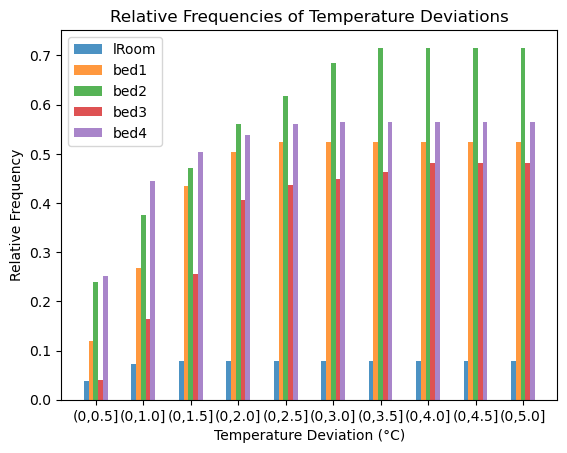

In [19]:
x = 0
y_values = np.arange(.5, 5.5, 0.5)  # Change the range of y_values if needed
rix_values = []

# Calculate the relative frequencies for each room and temperature interval
for room in rooms:
    room_rix = []
    for y in y_values:
        rix = calculate_rix(room, x, y, merged_df)
        room_rix.append(rix)
    rix_values.append(room_rix)

# Plot the relative frequencies
fig, ax = plt.subplots()
bar_width = 0.1
opacity = 0.8

for i, (room, rix) in enumerate(zip(rooms, rix_values)):
    index = np.arange(len(y_values))
    ax.bar(index + i * bar_width, rix, bar_width, alpha=opacity, label=room)

ax.set_xlabel('Temperature Deviation (°C)')
ax.set_ylabel('Relative Frequency')
ax.set_title('Relative Frequencies of Temperature Deviations')
ax.set_xticks(index + (len(rooms) - 1) * bar_width / 2)
ax.set_xticklabels([f'({x},{y}]' for y in y_values])
ax.legend()

plt.show()


In [20]:
def celsius_to_fahrenheit(temp):
    return temp * 9/5 + 32
def calculate_six_abs(instrument, x, merged_df):
    temperature_diff = np.abs(celsius_to_fahrenheit(merged_df[instrument]) - celsius_to_fahrenheit(merged_df['setpoint']))
    return set(merged_df.index[temperature_diff <= x])

def calculate_rix_abs(instrument, x, y, merged_df):
    six_y = calculate_six_abs(instrument, y, merged_df)
    six_x = calculate_six_abs(instrument, x, merged_df)
    si = len(merged_df)
    
    si_y = len(six_y)
    si_x = len(six_x)
    
    rix = (si_y - si_x) / si
    
    return rix


rooms = ['ex1','lRoom', 'bed1', 'bed2', 'bed3', 'bed4']

# Calculate the temperature difference for each sensor
for room in rooms:
    merged_df[f'{room}_diff'] = celsius_to_fahrenheit(merged_df[room]) - celsius_to_fahrenheit(merged_df['setpoint'])



The x-coordinate of the peak value for Thermostat is: 3


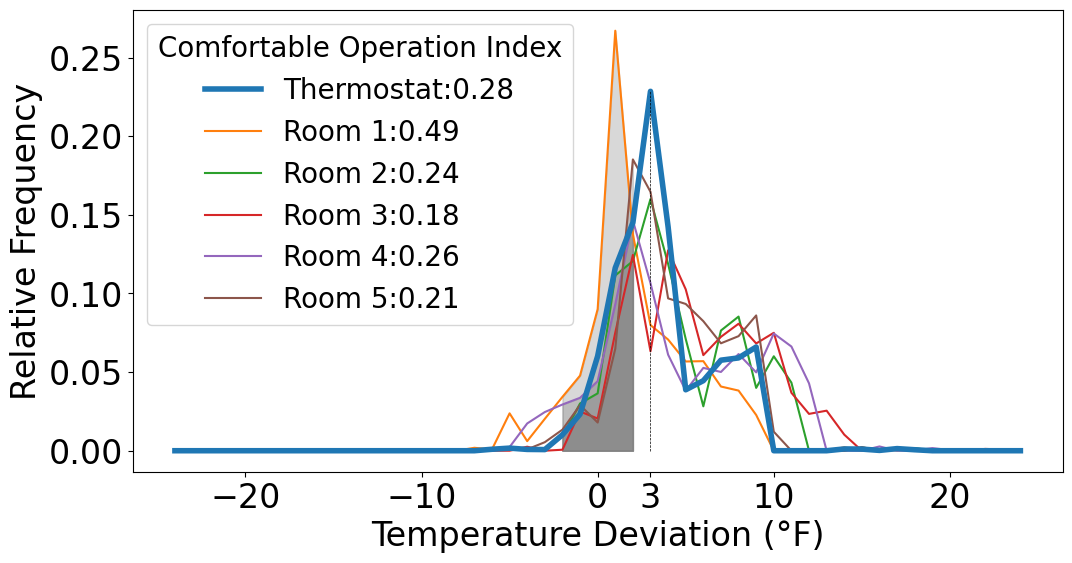

{'Thermostat': 0.2772609819121447, 'Room 1': 0.49080198429102934, 'Room 2': 0.24282296650717702, 'Room 3': 0.18317972350230413, 'Room 4': 0.2589932712215321, 'Room 5': 0.21111480128418025}


In [21]:

def plot_relative_frequencies(merged_df, rooms):
    x_values = np.arange(-math.ceil(abs_max_deviation), math.ceil(abs_max_deviation) + 1, 1)
    plt.figure(figsize=(12, 6))

    all_R_values = {}
    room_names = ['Thermostat', 'Room 1', 'Room 2', 'Room 3', 'Room 4', 'Room 5']
    comfort_metrics = {}

    for room, room_name in zip(rooms, room_names):
        R_values = []
        total_comf = 0
        comfort_2F = 0

        for x in x_values:
            Si_lower = merged_df[merged_df[f'{room}_diff'] <= x - 1]
            Si_upper = merged_df[merged_df[f'{room}_diff'] <= x]

            R = (len(Si_upper) - len(Si_lower)) / len(merged_df[f'{room}_diff'].dropna())
            R_values.append(R)
        
        all_R_values[room_name] = R_values

        # Compute the total area under the curve for this room
        total_comf = np.trapz(R_values, x_values)

        # Compute the area of the curve between -2F and 2F for this room
        comfort_2F = np.trapz([r for x, r in zip(x_values, R_values) if -2 <= x <= 2], x_values[(-2 <= x_values) & (x_values <= 2)])

        # Compute and store the comfort metric for this room
        comfort_metrics[room_name] = comfort_2F / total_comf if total_comf != 0 else 0

        # Make the line for 'Thermostat' thicker and add comfort metrics to the label
        if room_name == 'Thermostat':
            plt.plot(x_values, R_values, label=f'{room_name}:{round(comfort_metrics[room_name], 2)}', linewidth=4, zorder=10)
        else:
            plt.plot(x_values, R_values, label=f'{room_name}:{round(comfort_metrics[room_name], 2)}', zorder=1)

    # Determine the x-coordinate of the maximum y value in the 'Thermostat' series
    x_max = x_values[np.argmax(all_R_values['Thermostat'])]
    print(f'The x-coordinate of the peak value for Thermostat is: {x_max}')

    # Draw a dashed line at the x-coordinate of the maximum value in the 'Thermostat' series
    plt.vlines(x_max, ymin=0, ymax=max(all_R_values['Thermostat']), colors='black', linestyle='dashed', linewidths=0.5, zorder=11)

    # Add the x-coordinate of the peak value to the x-axis
    plt.gca().set_xticks(list(plt.gca().get_xticks()) + [x_max])

    for room_name, R_values in all_R_values.items():
        plt.fill_between(x_values, R_values, where=(-2 <= np.array(x_values)) & (np.array(x_values) <= 2), color='gray', alpha=0.3, zorder=0)

    plt.xlabel('Temperature Deviation (°F)', fontsize=24)
    plt.ylabel('Relative Frequency', fontsize=24)
    plt.legend(title='Comfortable Operation Index', title_fontsize='20', prop={'size': 20})

    plt.tick_params(axis='both', which='major', labelsize=24)
    plt.savefig('COI_house.pdf', format='pdf', dpi=300, bbox_inches='tight')
    plt.show()

    # Return the comfort metrics for each room
    return comfort_metrics


rooms = ['ex1','lRoom', 'bed1', 'bed2', 'bed3', 'bed4']

# Calculate the temperature difference for each sensor
for room in rooms:
    merged_df[f'{room}_diff'] = celsius_to_fahrenheit(merged_df[room]) - celsius_to_fahrenheit(merged_df['setpoint'])

# Find absolute maximum deviation
max_deviations = [merged_df[f'{room}_diff'].max() for room in rooms]
min_deviations = [merged_df[f'{room}_diff'].min() for room in rooms]
abs_max_deviation = max(max(max_deviations), abs(min(min_deviations)))

# Now call the function with the merged dataframe and the room names
comfort_metrics = plot_relative_frequencies(merged_df, rooms)
print(comfort_metrics)
